In [1]:
### General imports ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from imutils import face_utils

### CNN models ###
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras.regularizers import l2#, activity_l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model

Using TensorFlow backend.
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [2]:
os.chdir("..")
local_path = os.path.join(os.getcwd(), "dataset")

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'  #to suppress SettingWithCopyWarning

#Reading the dataset
data = os.path.join(local_path, "face_data.csv")
dataset = pd.read_csv(data)

#Obtaining train data where usage is "Training"
train = dataset[dataset["Usage"] == "Training"]

# #Obtaining test data where usage is "PublicTest"
test = dataset[dataset["Usage"] == "PublicTest"]

# #Converting " " separated pixel values to list
train['pixels'] = train['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
test['pixels'] = test['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))

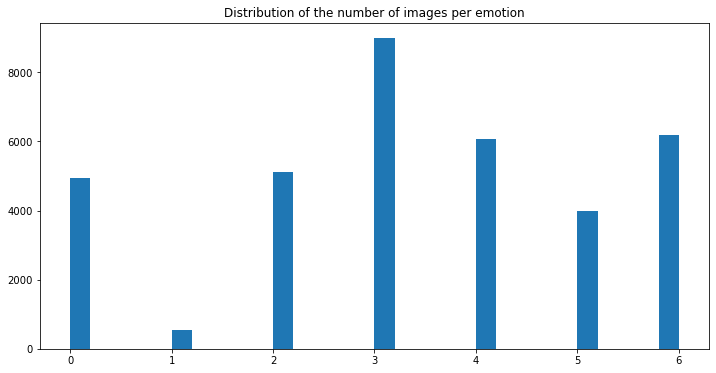

In [4]:
plt.figure(figsize=(12,6))
plt.hist(dataset['emotion'], bins=30)
plt.title("Distribution of the number of images per emotion")
plt.show()

In [5]:
shape_x = 48
shape_y = 48

In [6]:
X_train = train.iloc[:, 2].values
y_train = train.iloc[:, 0].values
X_test = test.iloc[:, 2].values
y_test = test.iloc[:, 0].values

#np.vstack stack arrays in sequence vertically (picking element row wise)
X_train_reshaped = np.vstack(X_train)
X_train_reshaped = np.concatenate((X_train_reshaped, X_train_reshaped, X_train_reshaped), axis=1)
X_test_reshaped = np.vstack(X_test)
X_test_reshaped = np.concatenate((X_test_reshaped, X_test_reshaped, X_test_reshaped), axis=1)
print(X_train_reshaped.shape)

#Reshape X_train, y_train,X_test,y_test in desired formats
X_train_reshaped = np.reshape(X_train_reshaped, (X_train_reshaped.shape[0], 48, 48, 3))
y_train = np.reshape(y_train, (y_train.shape[0], 1))
X_test_reshaped = np.reshape(X_test_reshaped, (X_test_reshaped.shape[0], 48, 48, 3))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print("Shape of X_train and y_train is " + str(X_train_reshaped.shape) +" and " + str(y_train.shape) +" respectively.")
print("Shape of X_test and y_test is " + str(X_test_reshaped.shape) +" and " + str(y_test.shape) +" respectively.")

(28709, 6912)
Shape of X_train and y_train is (28709, 48, 48, 3) and (28709, 1) respectively.
Shape of X_test and y_test is (3589, 48, 48, 3) and (3589, 1) respectively.


In [7]:
# Change to float datatype
train_data_reshaped = X_train_reshaped.astype('float32')
test_data_reshaped = X_test_reshaped.astype('float32')

# Scale the data to lie between 0 to 1
train_data_reshaped /= 255
test_data_reshaped /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(y_train)
test_labels_one_hot = to_categorical(y_test)

In [8]:
# Find the unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = X_train_reshaped.shape[1:]
input_shape = (nRows, nCols, nDims)

Total number of outputs :  7
Output classes :  [0 1 2 3 4 5 6]


In [9]:
def detect_face(frame):
    #Cascade classifier pre-trained model
    cascPath = os.path.join(os.getcwd(), "Models", "FaceDetect", "haarcascade_frontalface_default.xml")
    faceCascade = cv2.CascadeClassifier(cascPath)
    
    #BGR -> Gray conversion
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    #Cascade MultiScale classifier
    detected_faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=6,
                                                  minSize=(shape_x, shape_y),
                                                  flags=cv2.CASCADE_SCALE_IMAGE)
    coord = []
    
    for x, y, w, h in detected_faces :
        if w > 100 :
            sub_img=frame[y:y+h,x:x+w]
            #cv2.rectangle(frame,(x,y),(x+w,y+h),(0, 255,255),1)
            coord.append([x,y,w,h])
    
    return gray, detected_faces, coord

In [10]:
def extract_face_features(faces, offset_coefficients=(0.075, 0.05)):
    gray = faces[0]
    detected_face = faces[1]
    new_face = []
    
    for det in detected_face :
        x, y, w, h = det
    
        #Offset coefficient, np.floor takes the lowest integer (delete border of the image)
        horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
        vertical_offset = np.int(np.floor(offset_coefficients[1] * h))

        #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]
    
        new_extracted_face = zoom(extracted_face, (shape_x / extracted_face.shape[0],shape_y / extracted_face.shape[1]))
        #cast type float
        new_extracted_face = new_extracted_face.astype(np.float32)
        #scale
        new_extracted_face /= float(new_extracted_face.max())
        #print(new_extracted_face)
    
        new_face.append(new_extracted_face)
    
    return new_face

In [11]:
from keras.applications import ResNet152V2

base_model = ResNet152V2(include_top=False, input_shape=(shape_x, shape_y, 3),
                        weights="imagenet")
output = base_model.output
output = GlobalAveragePooling2D()(output)
output = Dense(512, activation="relu")(output)
output = Dense(7, activation="softmax")(output)

resnet = Model(inputs=base_model.input, outputs=output)


234553344/234545216 [==============================] - 42s 0us/step


In [12]:
resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 26, 26, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [13]:
resnet.compile(optimizer='adam', 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

In [17]:
plot_model(resnet, to_file='ResNet152V2_Model.png', show_shapes=True, show_layer_names=True)

In [14]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

In [15]:
batch_size = 256
epochs = 100

In [ ]:
with tf.device("/gpu:0"):
        history = resnet.fit_generator(
            datagen.flow(train_data_reshaped, train_labels_one_hot, batch_size=batch_size),
            steps_per_epoch=int(np.ceil(train_data_reshaped.shape[0] / float(batch_size))),
            epochs = epochs, 
            validation_data=(test_data_reshaped, test_labels_one_hot),
            callbacks=[
                ModelCheckpoint("./checkpoint_{epoch:02d}-{val_loss:.2f}.h5",
                           monitor="val_accuracy",
                           save_best_only=True,
                           mode="auto"),
                TensorBoard(log_dir="./l"),
                EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=25)
            ]
        )